In [1]:
%config Completer.use_jedi = False

from utils import *
import os
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
from scipy import signal

In [15]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [6,4]

In [3]:
# theory Tc value
TTc = 2/np.log(1+np.sqrt(2))

In [4]:
import pystan

In [20]:
stan_code = """
data {
    int N;
    vector[N] y;
    vector[N] x;
    real y_std;
    real a_prior;
    real b_prior;
    real p_prior;
    real error_precentage;
}
transformed data {
    
}
parameters {
    real a;
    real b;
    real p;
}
transformed parameters {
}
model {
    a ~ normal(a_prior, square(a_prior*error_precentage));
    b ~ normal(b_prior, square(b_prior*error_precentage));
    p ~ normal(p_prior, square(p_prior*error_precentage));
    
    y ~ normal(a-b*square(x-p), square(y_std));
}
generated quantities {
}
"""

In [21]:
if os.path.exists("./stan_model.pkl") is False or True:
    print("Compilling model...")
    sm = pystan.StanModel(model_code=stan_code)
    with open("./stan_model.pkl", "wb") as f:
        pickle.dump((stan_code, sm), f)
else:
    print("Loading compiled model...")
    with open("./stan_model.pkl", "rb") as f:
        _, sm = pickle.load(f)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67397f9ee1919cf05bbc0e22ca36d079 NOW.


Compilling model...


In [74]:
def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
popt, popt_cov = curve_fit(f, temp, C, maxfev=5000, 
                          p0=[TTc+0.3, C.mean(), 100])
popt_err = popt_cov.diagonal()**0.5
p_prior, a_prior, b_prior = popt
error_precentage = 0.3

In [75]:
eps = (C - f(temp, *popt))

In [76]:
np.sqrt(np.std(eps)/popt[2])

0.0445815153255752

In [77]:
popt[2]

0.592892293553141

In [78]:
np.std(eps)

0.0011783802568709303

In [56]:
fit = sm.sampling(data={"N":len(temp), "x":temp, "y":C, "y_std":C.std(), 
                        "a_prior":a_prior, "b_prior":b_prior, "p_prior":p_prior, "error_precentage":error_precentage
                            }, iter=5000, chains=8, 
                        )

In [57]:
lb = fit.extract(pars=["a", "b", "p"],permuted=False, inc_warmup=False);

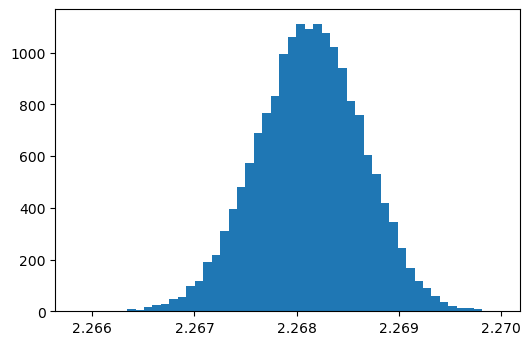

In [61]:
# plt.hist(lb["p"][:,0], bins=50);
ps = lb["p"].flatten()
ps = ps[ps<2.4]
plt.hist(ps, bins=50);

In [62]:
np.mean(ps), np.std(ps)

(2.268128661588515, 0.0005167962814087959)

In [63]:
popt[0], popt_err[0]

(2.2681367274391118, 0.0013788882705942434)

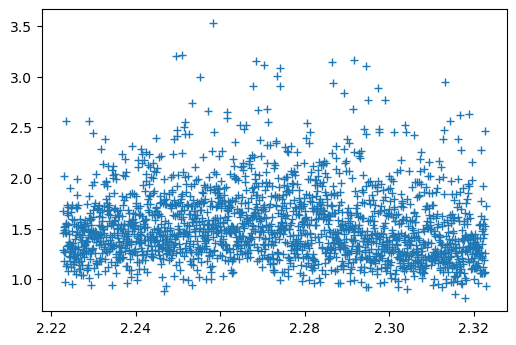

In [53]:
plt.plot(temp, C, "+")

In [ ]:
def main():
    
    print("Reading data...")
    data03 = pd.read_csv("../data/forced_oscillations_0.3A.csv", )[["angular frequency", "average / arbitrary units"]].rename(
        columns={"angular frequency": "o", "average / arbitrary units": "x"})
    data06 = pd.read_csv("../data/forced_oscillations_0.6A.csv", )[["angular frequency", "average / arbitrary units"]].rename(
        columns={"angular frequency": "o", "average / arbitrary units": "x"})

    def sample_from_prior(data):
        fit = sm.sampling(data={"N":len(data["o"]), "omega":data["o"].values, "x":data["x"].values, "l_x":1/0.1**2,
        #                         "alpha":alpha, "beta":beta, "gamma": gamma
                            }, iter=500000, chains=8, 
                        )

        lb = fit.extract(pars=["omega0", "x0", "gm"],permuted=False, inc_warmup=False);
        return lb["omega0"], lb["x0"], lb["gm"]

        omega0, x0, gm = np.mean(lb["omega0"]), np.mean(lb["x0"]), np.mean(lb["gm"])
        d_omega0, d_x0, d_gm = np.std(lb["omega0"]), np.std(lb["x0"]),np.std(lb["gm"])
        Q = omega0 / (2*gm)
        d_Q = np.sqrt((d_omega0/omega0)**2 + (d_gm/gm)**2)*Q
        print("x0:     %0.4f ± %0.4f" % (x0, d_x0))
        print("omega0: %0.5f ± %0.5f" % (omega0, d_omega0))
        print("gamma:  %0.5f ± %0.5f" % (gm, d_gm))
        print("Q:      %0.5f ± %0.5f" % (Q, d_Q))

        

    with open("samples.I=03.pkl", "wb") as f:
        pickle.dump(sample_from_prior(data03), f)
        print("\nsamples are saved in \"samples.I=03.pkl\"")

    
    with open("samples.I=06.pkl", "wb") as f:
        pickle.dump(sample_from_prior(data06), f)
        print("\nsamples are saved in \"samples.I=06.pkl\"")

if __name__ == "__main__":
    main()

# Load data from simulation 

In [8]:
with open("heat-capac-4-44-help.pkl", "rb")as ff:
    NtoT = pickle.load(ff)
NtoT[2] = 2.51

In [9]:
with open("heat-capac-2-96.pkl", "rb") as f:
    results = pickle.load(f)

In [10]:
df = pd.DataFrame(results, columns=["N", "temp", "len(Es)", "pos1","pos2", "mean_E", "std_E", "E^3", "E^4"])
df["C"] = df.std_E**2/df.temp**2

In [11]:
gb = df.groupby("N")

# Find peaks

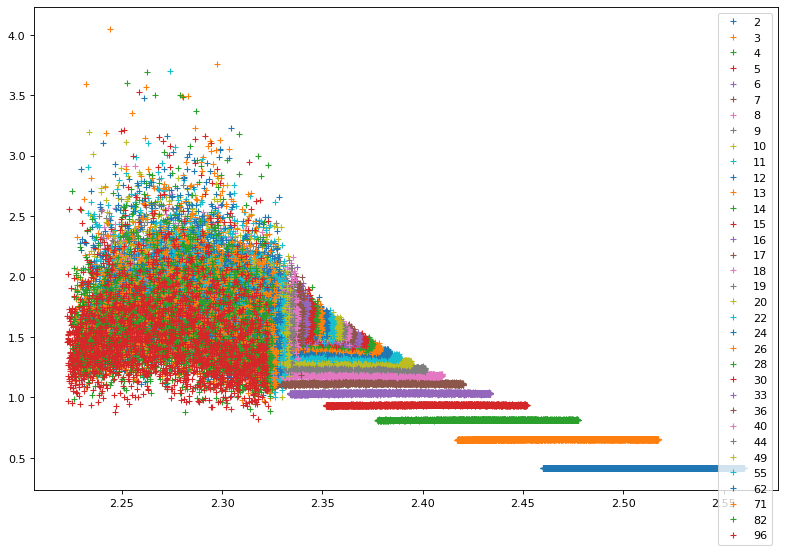

In [12]:
Ns = []
Tcs3 = []
Tcs3_err = []

w = 91

for N in gb.groups:
    Ns.append(N)
    
    df4 = gb.get_group(N)
    temp, C = df4.temp.values, (df4.C/N**2).values
    plt.plot(temp, C,"+", label=f"{N}")
   
    def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
    try:
        popt, popt_cov = curve_fit(f, temp, C, maxfev=5000, 
                                  p0=[TTc+0.3, C.mean(), 100])
        Tcs3.append(popt[0])
        Tcs3_err.append(popt_cov[0,0]**0.5)
        
        
    except Exception as e:
        Tcs3.append(np.nan)
        Tcs3_err.append(np.nan)
        print("1)", N, e)
   
    temp, C = df4.temp.iloc[w//2:-(w//2)], moving_average(df4.C.values/N**2, w=w)
    

plt.legend()
Ns, Tcs3, Tcs3_err = arrayify(Ns, Tcs3, Tcs3_err)

# check problematic N's

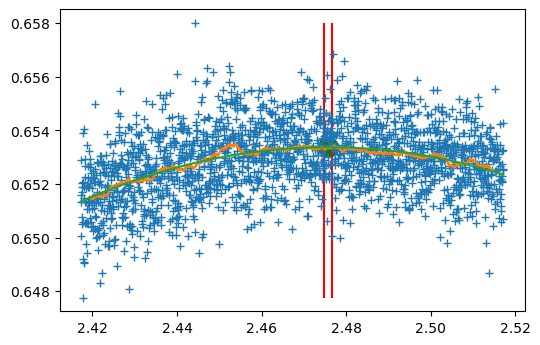

In [73]:
w=101
N=3
df4 = gb.get_group(N)
plt.plot(df4.temp, df4.C/N**2,"+", label=f"{N}")

temp, C = df4.temp.iloc[w//2:-(w//2)], moving_average(df4.C.values/N**2, w=w)
plt.plot(temp, C)
temp, C = df4.temp, df4.C/N**2

def f(x, p, a, b):
        return a - b*abs(x-(p))**(2)
# popt, popt_cov = curve_fit(f, df4.temp, df4.C/N**2, maxfev=5000, 
#                                   p0=[TTc+0.3, 1.5, 1])

popt, popt_cov = curve_fit(f, temp, C, maxfev=5000, 
                                  p0=[TTc+0.3, C.mean(), 100])
plt.plot(df4.temp, f(df4.temp, *popt))
plt.scatter(popt[0], f(popt[0], *popt), c="g", s=200)
plt.vlines(popt[0]-popt_cov[0,0]**0.5, ymin=min(df4.C/N**2), ymax=max(df4.C/N**2), color="r")
plt.vlines(popt[0]+popt_cov[0,0]**0.5, ymin=min(df4.C/N**2), ymax=max(df4.C/N**2), color="r")

# pid = find_peak(df4.C, l=5, r=30)
# plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="r")
# pid = find_peak(df4.C, l=10, r=60)
# plt.scatter(df4.temp.iloc[pid], df4.C.iloc[pid]/N**2, c="b", s=15)

# fit model

In [14]:
l,r=5,-15
def f(x, Tc, a, nu):
    return Tc + a / (x ** (1/nu))
popt3, popt3_cov = curve_fit(f, Ns[l:r], Tcs3[l:r], sigma=np.array(Tcs3_err)[l:r])

Tc, a, mu = popt3
print(f"T={Tc:0.4f} a={a:0.3f} mu={mu:0.3f}    Tc = {TTc:0.5f}")
Tc_err, a_err, mu_err = np.sqrt(popt3_cov.diagonal())
print(f"T={Tc_err:0.4f} a={a_err:0.6f} mu={mu_err:0.6f}")


T=2.2709 a=0.685 mu=1.033    Tc = 2.26919
T=0.0036 a=0.052891 mu=0.059226


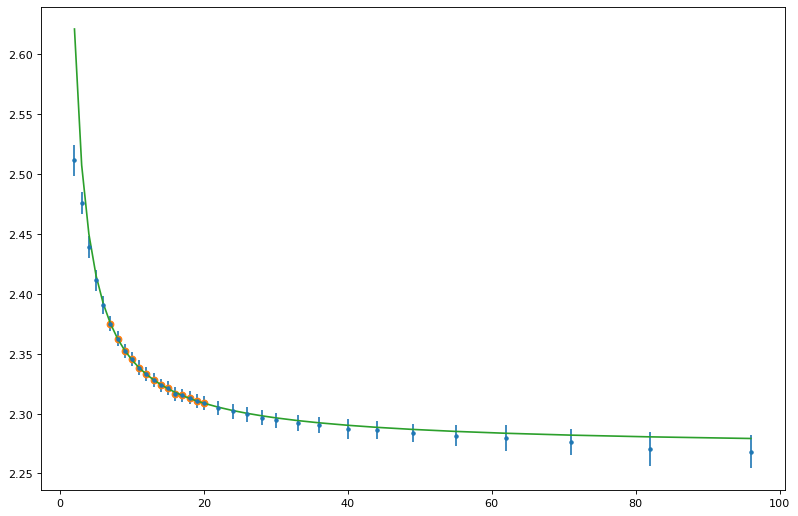

In [16]:
plt.errorbar(Ns, Tcs3, yerr=np.array(Tcs3_err)*10, fmt=".")
plt.plot(Ns[l:r], Tcs3[l:r], "o")
plt.plot(Ns, f(np.array(Ns), *popt3))

# Guess $\nu=1$

In [42]:
l,r=5,-5
def f(x, Tc, a):
    return Tc + a * x
popt3, popt3_cov = curve_fit(f, 1/Ns[l:r], Tcs3[l:r], sigma=np.array(Tcs3_err)[l:r])

Tc, a = popt3
print(f"T={Tc:0.4f} a={a:0.3f}   Tc = {TTc:0.5f}")
Tc_err, a_err = np.sqrt(popt3_cov.diagonal())*3
print(f"T={Tc_err:0.4f} a={a_err:0.6f}     {Tc-Tc_err:0.4f}..{Tc+Tc_err:0.4f}")


T=2.2706 a=0.742   Tc = 2.26919
T=0.0014 a=0.019457     2.2692..2.2720


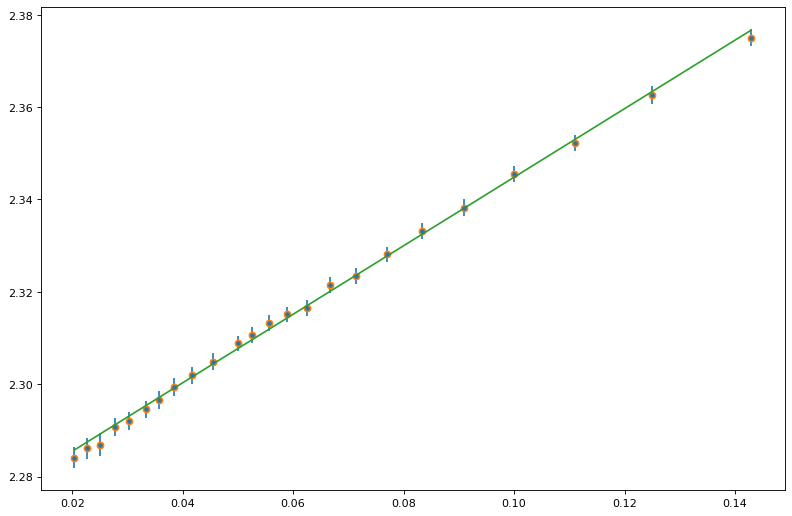

In [43]:
# plt.errorbar(1/Ns, Tcs3, yerr=Tcs3_err*10, fmt=".")
plt.errorbar(1/Ns[l:r], Tcs3[l:r], yerr=Tcs3_err[l:r]*3, fmt=".")
plt.plot(1/Ns[l:r], Tcs3[l:r], "o")
plt.plot(1/Ns[l:r], f(np.array(1/Ns[l:r]), *popt3))
# plt.gca().set_xscale("log")